<a href="https://colab.research.google.com/github/KillerStrike17/EVA-5/blob/master/5.%20Code%20Drill/EVA5_Code_Drill_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is Version 2 of the code drill

The main focus here is to get a model which gives decent accuracy in 10K parameters

## Importing Libraries



In [1]:
import torch 
import torch.nn as nn # All NN Layers
import torch.nn.functional as F # to get loss fucnction
import torch.optim as optim # Optimizer Fucntion
from torchvision import datasets, transforms #Loading Dataset and transform function to perform transformation
from torchsummary import summary # To view summary
%matplotlib inline
import matplotlib.pyplot as plt # To plot graphs
from torch.optim.lr_scheduler import StepLR,OneCycleLR, ReduceLROnPlateau
from tqdm import tqdm


## Data Transformation

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(), # Converting to Tensor
                                       transforms.Normalize((0.1307,),(0.3081,)) # Normalizing the dataset with the mean and std 
                                      ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                    transforms.ToTensor(), # Converting to Tensor
                                    transforms.Normalize((0.1307,),(0.3081,))  # Normalizing the dataset using mean and std
                                  ])

## Dataset Cleaning and Train/Test Split

In [3]:
train = datasets.MNIST('./data',train= True,download= True, transform = train_transforms) # Downloading Train set
test = datasets.MNIST('./data',train= False,download= True, transform = test_transforms) # Downloading Test set

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## CONSTANTS

In [4]:
SEED = 1
BATCHSIZE = 128
BATCHSIZE_2 = 64
NUM_OF_WORKER = 4
EPOCHS = 15

## Data Loading

In [5]:
# Checking for CUDA
cuda = torch.cuda.is_available()
print("CUDA Available",cuda)

torch.manual_seed(SEED)
if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args= dict(shuffle = True, batch_size = BATCHSIZE, num_workers = NUM_OF_WORKER,pin_memory = True) if cuda else dict(shuffle = True, batch_size  = BATCHSIZE_2)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args) # creating train data loader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args) # creating test dataloader

CUDA Available True


## The Model

In [6]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    # Convolution Block 1
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(9)
    )

    # Convolution Block 2
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=9,out_channels=18,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(18)
    )

    # Transition Block 1
    self.transitionblock1 = nn.Sequential(
        nn.Conv2d(in_channels = 18,out_channels = 12,kernel_size = (1,1),padding = 0,bias = False),
        nn.MaxPool2d(2,2)
    )

    # Convolution Block 3
    self.convblock3= nn.Sequential(
        nn.Conv2d(in_channels=12,out_channels=18,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(18)
    )

    # Convolution Block 4
    self.convblock4= nn.Sequential(
        nn.Conv2d(in_channels=18,out_channels=18,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(18)
    )

    self.convblock5= nn.Sequential(
        nn.Conv2d(in_channels=18,out_channels=18,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(18)
    )

    self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=5),
        nn.Conv2d(in_channels=18,out_channels=10,kernel_size=(1,1),padding = 0, bias = True)
    )
  
  def forward(self, x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.transitionblock1(x)
    x = self.convblock3(x)
    x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.gap(x)
    x = x.view(-1,10)
    return F.log_softmax(x,dim = -1)



## Model Parameters
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 26, 26]              81
              ReLU-2            [-1, 9, 26, 26]               0
       BatchNorm2d-3            [-1, 9, 26, 26]              18
            Conv2d-4           [-1, 18, 24, 24]           1,458
              ReLU-5           [-1, 18, 24, 24]               0
       BatchNorm2d-6           [-1, 18, 24, 24]              36
            Conv2d-7           [-1, 12, 24, 24]             216
         MaxPool2d-8           [-1, 12, 12, 12]               0
            Conv2d-9           [-1, 18, 10, 10]           1,944
             ReLU-10           [-1, 18, 10, 10]               0
      BatchNorm2d-11           [-1, 18, 10, 10]              36
           Conv2d-12             [-1, 18, 8, 8]           2,916
             ReLU-13             [-1, 18, 8, 8]               0
      BatchNorm2d-14             [-1, 1

In [8]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [9]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.08651014417409897 Batch_id=468 Accuracy=91.43: 100%|██████████| 469/469 [00:11<00:00, 39.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0861, Accuracy: 9755/10000 (97.55%)

EPOCH: 1


Loss=0.11836842447519302 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:11<00:00, 40.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0532, Accuracy: 9859/10000 (98.59%)

EPOCH: 2


Loss=0.03963141515851021 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:11<00:00, 40.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0409, Accuracy: 9890/10000 (98.90%)

EPOCH: 3


Loss=0.017425067722797394 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:11<00:00, 39.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9910/10000 (99.10%)

EPOCH: 4


Loss=0.017996303737163544 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:11<00:00, 40.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9889/10000 (98.89%)

EPOCH: 5


Loss=0.01948641799390316 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:11<00:00, 40.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9917/10000 (99.17%)

EPOCH: 6


Loss=0.05039143189787865 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 40.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.01476381067186594 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:11<00:00, 40.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9909/10000 (99.09%)

EPOCH: 8


Loss=0.0051792822778224945 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:11<00:00, 40.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.00207898928783834 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:11<00:00, 40.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9927/10000 (99.27%)

EPOCH: 10


Loss=0.01792907901108265 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:11<00:00, 40.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9936/10000 (99.36%)

EPOCH: 11


Loss=0.0032970986794680357 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:11<00:00, 40.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.012504379265010357 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:11<00:00, 40.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9914/10000 (99.14%)

EPOCH: 13


Loss=0.023020153865218163 Batch_id=468 Accuracy=99.60: 100%|██████████| 469/469 [00:11<00:00, 40.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9932/10000 (99.32%)

EPOCH: 14


Loss=0.029211392626166344 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:11<00:00, 40.56it/s]



Test set: Average loss: 0.0258, Accuracy: 9921/10000 (99.21%)



Text(0.5, 1.0, 'Test Accuracy')

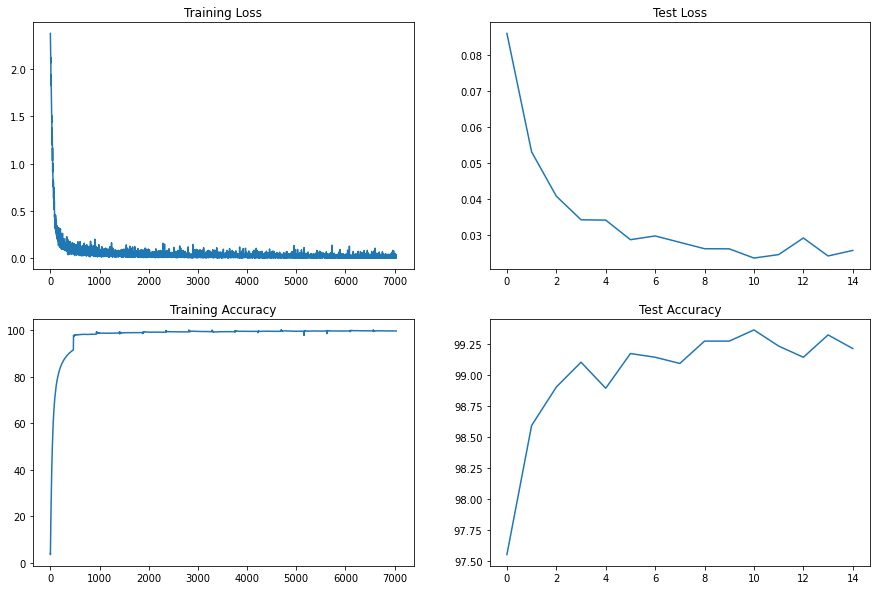

In [10]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")